In [1]:
import torch
torch.manual_seed(10)
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn import decomposition
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
import nltk
#Import stopwords
from nltk.corpus import stopwords

In [2]:
corpus = [
    'drink milk',
    'drink cold water',
    'drink cold cola',
    'drink juice',
    'drink cola',
    'eat bacon',
    'eat mango',
    'eat cherry',
    'eat apple',
    'juice with sugar',
    'cola with sugar',
    'mango is fruit',
    'apple is fruit',
    'cherry is fruit',
    'Berlin is Germany',
    'Boston is USA',
    'Mercedes from Germany',
    'Mercedes is a car',
    'Ford from USA',
    'Ford is a car',
    'Abhay is a great guy'
]

Skip-Gram model tries to predict context given a word. So as input it expect word and as output words which often appears with the inputed one. Below I implement some suportive functions.

In [3]:
def create_vocabulary(corpus):
    '''Creates a dictionary with all unique words in corpus with id'''
    vocabulary = {}
    i = 0
    for s in corpus:
        for w in s.split():
            if w not in vocabulary:
                vocabulary[w] = i
                i+=1
    return vocabulary

def prepare_set(corpus, n_gram = 1):
    '''Creates a dataset with Input column and Outputs columns for neighboring words. 
       The number of neighbors = n_gram*2'''
    columns = ['Input'] + [f'Output{i+1}' for i in range(n_gram*2)]
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = [w]
            out = []
            for n in range(1,n_gram+1):
                # look back
                if (i-n)>=0:
                    out.append(sentence.split()[i-n])
                else:
                    out.append('<padding>')
                
                # look forward
                if (i+n)<len(sentence.split()):
                    out.append(sentence.split()[i+n])
                else:
                    out.append('<padding>')
            row = pd.DataFrame([inp+out], columns = columns)
            result = result.append(row, ignore_index = True)
    return result

def prepare_set_ravel(corpus, n_gram = 1):
    '''Creates a dataset with Input column and Output column for neighboring words. 
       The number of neighbors = n_gram*2'''
    columns = ['Input', 'Output']
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = w
            for n in range(1,n_gram+1):
                # look back
                if (i-n)>=0:
                    out = sentence.split()[i-n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = result.append(row, ignore_index = True)
                
                # look forward
                if (i+n)<len(sentence.split()):
                    out = sentence.split()[i+n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = result.append(row, ignore_index = True)
    return result

In [4]:
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    result = []
    for i in corpus:
        out = nltk.word_tokenize(i)
        out = [x.lower() for x in out]
        out = [x for x in out if x not in stop_words]
        result.append(" ". join(out))
    return result

corpus = preprocess(corpus)
corpus

['drink milk',
 'drink cold water',
 'drink cold cola',
 'drink juice',
 'drink cola',
 'eat bacon',
 'eat mango',
 'eat cherry',
 'eat apple',
 'juice sugar',
 'cola sugar',
 'mango fruit',
 'apple fruit',
 'cherry fruit',
 'berlin germany',
 'boston usa',
 'mercedes germany',
 'mercedes car',
 'ford usa',
 'ford car',
 'abhay great guy']

In [5]:
vocabulary = create_vocabulary(corpus)
vocabulary

{'drink': 0,
 'milk': 1,
 'cold': 2,
 'water': 3,
 'cola': 4,
 'juice': 5,
 'eat': 6,
 'bacon': 7,
 'mango': 8,
 'cherry': 9,
 'apple': 10,
 'sugar': 11,
 'fruit': 12,
 'berlin': 13,
 'germany': 14,
 'boston': 15,
 'usa': 16,
 'mercedes': 17,
 'car': 18,
 'ford': 19,
 'abhay': 20,
 'great': 21,
 'guy': 22}

In [6]:
train_emb = prepare_set(corpus, n_gram = 2)
train_emb.head()

,Input,Output1,Output2,Output3,Output4
0,drink,<padding>,milk,<padding>,<padding>
1,milk,drink,<padding>,<padding>,<padding>
2,drink,<padding>,cold,<padding>,water
3,cold,drink,water,<padding>,<padding>
4,water,cold,<padding>,drink,<padding>


In [7]:
train_emb = prepare_set_ravel(corpus, n_gram = 2)
train_emb.head()

,Input,Output
0,drink,milk
1,milk,drink
2,drink,cold
3,drink,water
4,cold,drink


In [8]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head()

,Input,Output
0,0,1
1,1,0
2,0,2
3,0,3
4,2,0


In [9]:
vocab_size = len(vocabulary)

def get_input_tensor(tensor):
    '''Transform 1D tensor of word indexes to one-hot encoded 2D tensor'''
    size = [*tensor.shape][0]
    inp = torch.zeros(size, vocab_size).scatter_(1, tensor.unsqueeze(1), 1.)
    return Variable(inp).float()

In [16]:

embedding_dims = 5
device = torch.device('cpu')

In [17]:
initrange = 0.5 / embedding_dims
W1 = Variable(torch.randn(vocab_size, embedding_dims, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) # shape V*H
W2 = Variable(torch.randn(embedding_dims, vocab_size, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) #shape H*V
print(f'W1 shape is: {W1.shape}, W2 shape is: {W2.shape}')

W1 shape is: torch.Size([23, 5]), W2 shape is: torch.Size([5, 23])


In [18]:
num_epochs = 2000
learning_rate = 2e-1
lr_decay = 0.99
loss_hist = []

In [19]:
%%time
for epo in range(num_epochs):
    for x,y in zip(DataLoader(train_emb.Input.values, batch_size=train_emb.shape[0]), DataLoader(train_emb.Output.values, batch_size=train_emb.shape[0])):
        
        # one-hot encode input tensor
        input_tensor = get_input_tensor(x) #shape N*V
     
        # simple NN architecture
        h = input_tensor.mm(W1) # shape 1*H
        y_pred = h.mm(W2) # shape 1*V
        
        # define loss func
        loss_f = torch.nn.CrossEntropyLoss() # see details: https://pytorch.org/docs/stable/nn.html
        
        #compute loss
        loss = loss_f(y_pred, y)
        
        # bakpropagation step
        loss.backward()
        
        # Update weights using gradient descent. For this step we just want to mutate
        # the values of w1 and w2 in-place; we don't want to build up a computational
        # graph for the update steps, so we use the torch.no_grad() context manager
        # to prevent PyTorch from building a computational graph for the updates
        with torch.no_grad():
            # SGD optimization is implemented in PyTorch, but it's very easy to implement manually providing better understanding of process
            W1 -= learning_rate*W1.grad.data
            W2 -= learning_rate*W2.grad.data
            # zero gradients for next step
            W1.grad.data.zero_()
            W1.grad.data.zero_()
    if epo%10 == 0:
        learning_rate *= lr_decay
    loss_hist.append(loss)
    if epo%50 == 0:
        print(f'Epoch {epo}, loss = {loss}')

Epoch 0, loss = 3.1364731788635254
Epoch 50, loss = 2.811692237854004
Epoch 100, loss = 1.5684239864349365
Epoch 150, loss = 1.051347255706787
Epoch 200, loss = 0.8983984589576721
Epoch 250, loss = 0.8838306665420532
Epoch 300, loss = 1.0180493593215942
Epoch 350, loss = 1.0002667903900146
Epoch 400, loss = 1.102177619934082
Epoch 450, loss = 1.2439196109771729
Epoch 500, loss = 1.0563956499099731
Epoch 550, loss = 1.1015840768814087
Epoch 600, loss = 1.120414137840271
Epoch 650, loss = 1.1154431104660034
Epoch 700, loss = 1.1715660095214844
Epoch 750, loss = 1.1530464887619019
Epoch 800, loss = 1.18901526927948
Epoch 850, loss = 1.2286570072174072
Epoch 900, loss = 1.0439116954803467
Epoch 950, loss = 1.116196632385254
Epoch 1000, loss = 1.063172698020935
Epoch 1050, loss = 1.0090192556381226
Epoch 1100, loss = 0.9918757081031799
Epoch 1150, loss = 0.9619887471199036
Epoch 1200, loss = 0.9435533881187439
Epoch 1250, loss = 0.9396970272064209
Epoch 1300, loss = 0.9269164204597473
Epoch

In [20]:
W1 = W1.detach().numpy()
W2 = W2.T.detach().numpy()

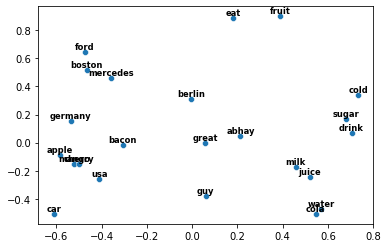

In [21]:
svd = decomposition.TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1)
x = W1_dec[:,0]
y = W1_dec[:,1]
plot = sns.scatterplot(x, y)

for i in range(0,W1_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');

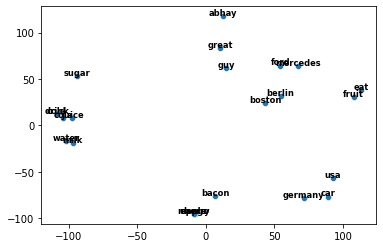

In [22]:
W2_dec = svd.fit_transform(W2)
x1 = W2_dec[:,0]
y1 = W2_dec[:,1]
plot1 = sns.scatterplot(x1, y1)
for i in range(0,W2_dec.shape[0]):
     plot1.text(x1[i], y1[i]+1, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');